# Libraries

In [64]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

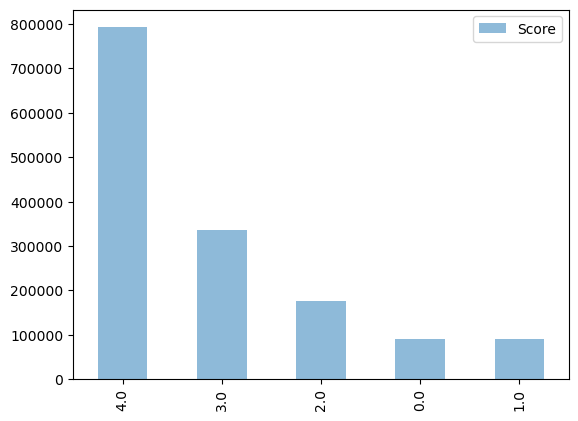


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [45]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

# NECESSARY FOR XGBOOST: [0, 1, 2, 3, 4]
trainingSet['Score'] = trainingSet['Score'] - 1

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [46]:
nltk.download('vader_lexicon')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
sia = SentimentIntensityAnalyzer()

# remove meaningless words and reduce words to their roots
def filter_and_lemmatize(text):
    if pd.isnull(text):
        return ''
    filtered = ' '.join([word for word in text.split() if word.lower() not in stop_words])
    return ' '.join([lemmatizer.lemmatize(word) for word in filtered.split()])

# calculate the sentiment of a text
def sentiment(text):
    if pd.isnull(text):
        return 0
    return sia.polarity_scores(filter_and_lemmatize(text))['compound']

def add_features_to(df):
    # This is where you can do all your feature extraction

    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)
   
    df['Summary Sentiment'] = df['Summary'].apply(sentiment)
    df['Text Sentiment'] = df['Text'].apply(sentiment)

    df['Length'] = df['Text'].str.len()
    df['Length'] = df['Length'].fillna(0)
    
    return df

# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv') and exists('./data/X_submission.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
    X_submission = pd.read_csv("./data/X_submission.csv")
else:
    # Process the DataFrame
    train = add_features_to(trainingSet)

    # calculate product stats
    product_stats = trainingSet.groupby('ProductId')['Score'].agg(['mean', 'var']).reset_index()
    product_stats.columns = ['ProductId', 'ProductMeanScore', 'ProductScoreVariance']

    # calculate user stats
    user_stats = trainingSet.groupby('UserId')['Score'].agg(['mean', 'var']).reset_index()
    user_stats.columns = ['UserId', 'UserMeanScore', 'UserScoreVariance']

    # merge product and user stats to train
    train = pd.merge(train, product_stats, on='ProductId', how='left')
    train = pd.merge(train, user_stats, on='UserId', how='left')
    
    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id', how='right')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # merge product stats to X_submission
    X_submission = pd.merge(X_submission, product_stats, on='ProductId', how='left')
    X_submission = X_submission.drop(columns=['ProductMeanScore_x', 'ProductScoreVariance_x'])
    X_submission = X_submission.rename(columns={'ProductMeanScore_y': 'ProductMeanScore', 'ProductScoreVariance_y': 'ProductScoreVariance'})

    # merge user stats to X_submission
    X_submission = pd.merge(X_submission, user_stats, on='UserId', how='left')
    X_submission = X_submission.drop(columns=['UserMeanScore_x', 'UserScoreVariance_x'])
    X_submission = X_submission.rename(columns={'UserMeanScore_y': 'UserMeanScore', 'UserScoreVariance_y': 'UserScoreVariance'})

    # fill in missing values with overall mean and variance
    overall_mean_score = trainingSet['Score'].mean()
    overall_score_variance = trainingSet['Score'].var()
    X_submission['ProductMeanScore'].fillna(overall_mean_score, inplace=True)
    X_submission['ProductScoreVariance'].fillna(overall_score_variance, inplace=True)

    # The training set is where the score is not null
    X_train = train[train['Score'].notnull()]

    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ariontripathi/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ariontripathi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/ariontripathi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Sample + Split into training and testing set

In [47]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)

# Feature Selection

In [61]:
features = [
    'Helpfulness',
    'HelpfulnessNumerator',
    'HelpfulnessDenominator',
    'Summary Sentiment',
    'Text Sentiment',
    'Length',
    'ProductMeanScore',
    'ProductScoreVariance',
    'UserMeanScore',
    'UserScoreVariance'
]

X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

# Model Creation

In [69]:
# hyperparameter tuning
param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
}

# Learn the model
grid_search = GridSearchCV(
    XGBClassifier(random_state=0),
    param_grid=param_grid,
    cv=2,
    verbose=3
)
grid_search.fit(X_train_select, Y_train)

# Predict the score using the model
Y_test_predictions = grid_search.predict(X_test_select)

Fitting 2 folds for each of 36 candidates, totalling 72 fits
[CV 1/2] END learning_rate=0.01, max_depth=6, n_estimators=100;, score=0.645 total time=  11.0s
[CV 2/2] END learning_rate=0.01, max_depth=6, n_estimators=100;, score=0.645 total time=  11.0s
[CV 1/2] END learning_rate=0.01, max_depth=6, n_estimators=150;, score=0.649 total time=  16.0s
[CV 2/2] END learning_rate=0.01, max_depth=6, n_estimators=150;, score=0.648 total time=  14.8s
[CV 1/2] END learning_rate=0.01, max_depth=6, n_estimators=200;, score=0.652 total time=  20.1s
[CV 2/2] END learning_rate=0.01, max_depth=6, n_estimators=200;, score=0.652 total time=  21.0s
[CV 1/2] END learning_rate=0.01, max_depth=6, n_estimators=250;, score=0.655 total time=  24.6s
[CV 2/2] END learning_rate=0.01, max_depth=6, n_estimators=250;, score=0.654 total time=  25.1s
[CV 1/2] END learning_rate=0.01, max_depth=8, n_estimators=100;, score=0.656 total time=  14.4s
[CV 2/2] END learning_rate=0.01, max_depth=8, n_estimators=100;, score=0.65

# Model Evaluation

Accuracy on testing set =  0.6830336945515652


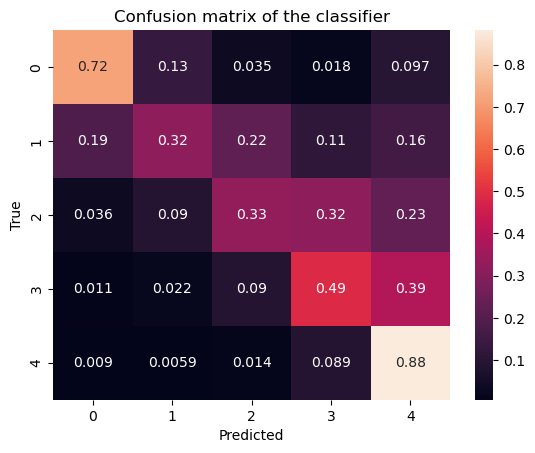

In [70]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [72]:
# Create the submission file
X_submission['Score'] = grid_search.predict(X_submission_select)
X_submission['Score'] = X_submission['Score'] + 1
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)